## Scraping data komen dari playstore aplikasi dana ##


In [25]:
from google_play_scraper import reviews, Sort
import pandas as pd

In [26]:
# Konfigurasi scraping
app_package_name = 'id.dana'  # package name aplikasi DANA di Play Store
total_comments = 1000  # jumlah komentar yang ingin diambil

all_reviews = []
count = 0

while len(all_reviews) < total_comments:
    result, _ = reviews(
        app_package_name,
        lang='id',  # Bahasa Indonesia
        country='id',  # Wilayah Indonesia
        sort=Sort.NEWEST,
        count=200,  # maksimal per fetch
        filter_score_with=None  # ambil semua skor
    )
    
    all_reviews.extend(result)
    count += 1
    
    print(f"Batch {count}: {len(result)} komentar diambil... Total: {len(all_reviews)}")
    
    if len(result) == 0:
        break  # hentikan jika tidak ada komentar lagi

Batch 1: 200 komentar diambil... Total: 200
Batch 2: 200 komentar diambil... Total: 400
Batch 3: 200 komentar diambil... Total: 600
Batch 4: 200 komentar diambil... Total: 800
Batch 5: 200 komentar diambil... Total: 1000


In [4]:

# Buat DataFrame
df = pd.DataFrame(all_reviews)
df = df[['userName', 'score', 'at', 'content']]

In [27]:
# Simpan ke CSV
df.to_csv('komentar_dana.csv', index=False, encoding='utf-8-sig')
print("Komentar berhasil disimpan ke 'komentar_dana.csv'")

Komentar berhasil disimpan ke 'komentar_dana.csv'


## preprocessing ##

In [37]:
# --- Import Library ---
import pandas as pd, re, unicodedata, pathlib
import nltk
from nltk.tokenize import TweetTokenizer

In [38]:
# --- Pastikan stopwords ada ---
nltk_data_dir = str(pathlib.Path.home() / "nltk_data")
if nltk_data_dir not in nltk.data.path:
    nltk.data.path.append(nltk_data_dir)
try:
    nltk.data.find("corpora/stopwords")
except LookupError:
    nltk.download("stopwords", download_dir=nltk_data_dir)

from nltk.corpus import stopwords
try:
    STOP_ID = set(stopwords.words("indonesian"))
    STOP_EN = set(stopwords.words("english"))
except LookupError:
    STOP_ID = {"yang","dan","di","ke","dari","untuk","pada","karena","dengan","atau","jadi","ada","tidak"}
    STOP_EN = {"the","is","are","to","for","in","on","at","and","or","of","a","an","with","this","that","it"}
STOP = STOP_ID | STOP_EN

In [39]:
# --- Load Data ---
df = pd.read_csv("komentar_dana.csv", encoding="utf-8-sig")

In [40]:
# Lihat beberapa sampel data
print(df.head())

           userName  score                   at  \
0          Bah Raen      5  2025-09-07 14:14:03   
1      Nisa Anggita      5  2025-09-07 14:10:23   
2  Prachi Aurellina      5  2025-09-07 14:07:56   
3       Wali redfox      1  2025-09-07 14:05:51   
4     Defri Cahdapi      1  2025-09-07 14:05:30   

                                             content  \
0  Kasih bintang 4 dulu karena baru pemula belum ...   
1                                 dana Memang Mantap   
2                                             baguus   
3      aplikasi tidak jelas, saldo tiba" berkurang..   
4  aplikasi dana jelek download baru disuruh upda...   

                                       clean_content  
0  kasih bintang 4 dulu karena baru pemula belum ...  
1                                 dana memang mantap  
2                                             baguus  
3      aplikasi tidak jelas, saldo tiba" berkurang..  
4  aplikasi dana jelek download baru disuruh upda...  


In [41]:
# Helper print
def show_step(title, series_like, N=5):
    print(f"\n=== {title} ===")
    for i, v in enumerate(series_like.head(N).tolist(), 1):
        print(f"{i}. {v}")

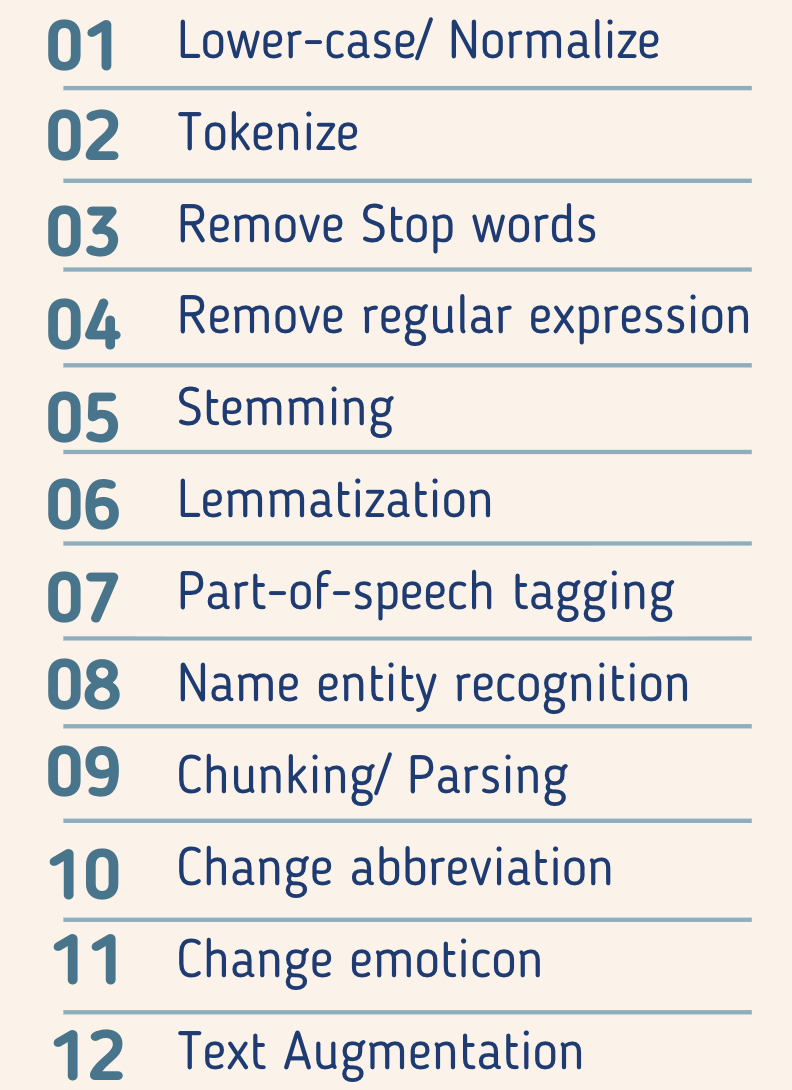

## 1 - 4 # 


In [42]:
# --- 1. Lower-case / Normalize ---
def normalize_text(s: str) -> str:
    s = str(s).lower()
    s = unicodedata.normalize("NFKC", s)
    s = re.sub(r"\s+", " ", s).strip()
    return s

df["p1_lower"] = df["content"].astype(str).apply(normalize_text)
show_step("1. Lower-case / Normalize", df["p1_lower"])



=== 1. Lower-case / Normalize ===
1. kasih bintang 4 dulu karena baru pemula belum tau kedepannya
2. dana memang mantap
3. baguus
4. aplikasi tidak jelas, saldo tiba" berkurang..
5. aplikasi dana jelek download baru disuruh update, udah di update gak bisa masuk disuruh nunggu besok.


In [43]:
# --- 2. Tokenize ---
tknzr = TweetTokenizer(preserve_case=False, strip_handles=False, reduce_len=True)
df["p2_tokens"] = df["p1_lower"].apply(lambda s: tknzr.tokenize(s))
show_step("2. Tokenize", df["p2_tokens"])


=== 2. Tokenize ===
1. ['kasih', 'bintang', '4', 'dulu', 'karena', 'baru', 'pemula', 'belum', 'tau', 'kedepannya']
2. ['dana', 'memang', 'mantap']
3. ['baguus']
4. ['aplikasi', 'tidak', 'jelas', ',', 'saldo', 'tiba', '"', 'berkurang', '..']
5. ['aplikasi', 'dana', 'jelek', 'download', 'baru', 'disuruh', 'update', ',', 'udah', 'di', 'update', 'gak', 'bisa', 'masuk', 'disuruh', 'nunggu', 'besok', '.']


In [44]:
# --- 3. Remove Stop Words ---
def remove_stopwords(tokens):
    return [t for t in tokens if t not in STOP]
df["p3_no_stop"] = df["p2_tokens"].apply(remove_stopwords)
show_step("3. Remove Stop Words", df["p3_no_stop"])



=== 3. Remove Stop Words ===
1. ['kasih', 'bintang', '4', 'pemula', 'tau', 'kedepannya']
2. ['dana', 'mantap']
3. ['baguus']
4. ['aplikasi', ',', 'saldo', '"', 'berkurang', '..']
5. ['aplikasi', 'dana', 'jelek', 'download', 'disuruh', 'update', ',', 'udah', 'update', 'gak', 'masuk', 'disuruh', 'nunggu', 'besok', '.']


In [45]:
# --- 4. Remove Regex ---
EMOJI_RANGES = r"\U0001F300-\U0001FAFF\U00002700-\U000027BF"
EMOJI_RE = re.compile(f"[{EMOJI_RANGES}]")
URL_RE = re.compile(r"https?://\S+|www\.\S+", flags=re.IGNORECASE)

def regex_clean(tokens):
    cleaned = []
    for tok in tokens:
        if URL_RE.search(tok):
            continue
        tok = re.sub(r"[@#]+", "", tok)      # hapus @, #
        if EMOJI_RE.search(tok):
            cleaned.append(tok)              # simpan emoji
            continue
        t = re.sub(r"[^0-9a-z]+", "", tok)   # hapus simbol/angka
        if t and t not in STOP:
            cleaned.append(t)
    return cleaned

df["p4_regex"] = df["p3_no_stop"].apply(regex_clean)
show_step("4. Remove Regex", df["p4_regex"])



=== 4. Remove Regex ===
1. ['kasih', 'bintang', '4', 'pemula', 'tau', 'kedepannya']
2. ['dana', 'mantap']
3. ['baguus']
4. ['aplikasi', 'saldo', 'berkurang']
5. ['aplikasi', 'dana', 'jelek', 'download', 'disuruh', 'update', 'udah', 'update', 'gak', 'masuk', 'disuruh', 'nunggu', 'besok']


## 5 - 8 ##

In [47]:
# --- 5. Stemming (pakai Sastrawi) ---
from Sastrawi.Stemmer.StemmerFactory import StemmerFactory
stemmer = StemmerFactory().create_stemmer()

df["p5_stem"] = df["p4_regex"].apply(lambda tokens: [stemmer.stem(t) for t in tokens])
show_step("5. Stemming", df["p5_stem"])


=== 5. Stemming ===
1. ['kasih', 'bintang', '4', 'mula', 'tau', 'depan']
2. ['dana', 'mantap']
3. ['baguus']
4. ['aplikasi', 'saldo', 'kurang']
5. ['aplikasi', 'dana', 'jelek', 'download', 'suruh', 'update', 'udah', 'update', 'gak', 'masuk', 'suruh', 'nunggu', 'besok']


In [48]:

# --- 6. Lemmatization (pakai WordNetLemmatizer untuk kata Inggris) ---
from nltk.stem import WordNetLemmatizer
nltk.download("wordnet", quiet=True)
nltk.download("omw-1.4", quiet=True)

lemmatizer = WordNetLemmatizer()
df["p6_lemma"] = df["p5_stem"].apply(lambda tokens: [lemmatizer.lemmatize(t) for t in tokens])
show_step("6. Lemmatization", df["p6_lemma"])


=== 6. Lemmatization ===
1. ['kasih', 'bintang', '4', 'mula', 'tau', 'depan']
2. ['dana', 'mantap']
3. ['baguus']
4. ['aplikasi', 'saldo', 'kurang']
5. ['aplikasi', 'dana', 'jelek', 'download', 'suruh', 'update', 'udah', 'update', 'gak', 'masuk', 'suruh', 'nunggu', 'besok']


In [50]:
# --- 7. POS Tagging (pakai spaCy) ---
import spacy
nlp = spacy.load("en_core_web_sm")

def pos_tag_tokens(tokens):
    doc = nlp(" ".join(tokens))
    return [(token.text, token.pos_) for token in doc]

df["p7_pos"] = df["p6_lemma"].apply(pos_tag_tokens)
show_step("7. POS Tagging", df["p7_pos"])


=== 7. POS Tagging ===
1. [('kasih', 'PROPN'), ('bintang', 'PROPN'), ('4', 'NUM'), ('mula', 'PROPN'), ('tau', 'PROPN'), ('depan', 'NOUN')]
2. [('dana', 'PROPN'), ('mantap', 'PROPN')]
3. [('baguus', 'NOUN')]
4. [('aplikasi', 'PROPN'), ('saldo', 'PROPN'), ('kurang', 'PROPN')]
5. [('aplikasi', 'PROPN'), ('dana', 'PROPN'), ('jelek', 'PROPN'), ('download', 'PROPN'), ('suruh', 'PROPN'), ('update', 'NOUN'), ('udah', 'PROPN'), ('update', 'PROPN'), ('gak', 'PROPN'), ('masuk', 'PROPN'), ('suruh', 'PROPN'), ('nunggu', 'PROPN'), ('besok', 'VERB')]


In [51]:
# --- 8. Named Entity Recognition (NER) ---
def ner_tokens(tokens):
    doc = nlp(" ".join(tokens))
    return [(ent.text, ent.label_) for ent in doc.ents]

df["p8_ner"] = df["p6_lemma"].apply(ner_tokens)
show_step("8. Named Entity Recognition", df["p8_ner"])


=== 8. Named Entity Recognition ===
1. [('kasih bintang 4', 'PERSON')]
2. [('dana mantap', 'PERSON')]
3. []
4. [('aplikasi saldo kurang', 'ORG')]
5. [('dana jelek', 'PERSON')]


## 9 - 12 ##

In [52]:
# --- 9. Chunking / Parsing ---
import spacy
try:
    nlp = spacy.load("en_core_web_sm")
except:
    nlp = spacy.blank("en")  # fallback kalau model belum ada

def chunk_parse(tokens):
    doc = nlp(" ".join(tokens))
    return [(chunk.text, chunk.label_) for chunk in doc.noun_chunks] if doc.has_annotation("DEP") else []

df["p9_chunk"] = df["p6_lemma"].apply(chunk_parse)
show_step("9. Chunking / Parsing", df["p9_chunk"])


=== 9. Chunking / Parsing ===
1. [('kasih bintang 4 mula', 'NP')]
2. [('dana mantap', 'NP')]
3. [('baguus', 'NP')]
4. [('aplikasi saldo kurang', 'NP')]
5. []


In [53]:
# --- 10. Change Abbreviation ---
abbrev_dict = {
    "gk": "tidak", "ga": "tidak", "nggak": "tidak",
    "tp": "tapi", "yg": "yang", "dr": "dari", "jd": "jadi",
    "dl": "dulu", "pls": "tolong", "thx": "terima kasih"
}

def expand_abbrev(tokens):
    return [abbrev_dict.get(t, t) for t in tokens]

df["p10_abbrev"] = df["p6_lemma"].apply(expand_abbrev)
show_step("10. Change Abbreviation", df["p10_abbrev"])



=== 10. Change Abbreviation ===
1. ['kasih', 'bintang', '4', 'mula', 'tau', 'depan']
2. ['dana', 'mantap']
3. ['baguus']
4. ['aplikasi', 'saldo', 'kurang']
5. ['aplikasi', 'dana', 'jelek', 'download', 'suruh', 'update', 'udah', 'update', 'gak', 'masuk', 'suruh', 'nunggu', 'besok']


In [54]:
# --- 11. Change Emoticon ---
emoji_map = {
    "😀": "senyum", "😢": "sedih", "😂": "ketawa", "😍": "suka",
    "😭": "nangis", "🙏": "terimakasih", "👌": "ok", "👍": "bagus", "👎": "jelek"
}

def map_emoticons(tokens):
    return [emoji_map.get(t, t) for t in tokens]

df["p11_emoji"] = df["p10_abbrev"].apply(map_emoticons)
show_step("11. Change Emoticon", df["p11_emoji"])


=== 11. Change Emoticon ===
1. ['kasih', 'bintang', '4', 'mula', 'tau', 'depan']
2. ['dana', 'mantap']
3. ['baguus']
4. ['aplikasi', 'saldo', 'kurang']
5. ['aplikasi', 'dana', 'jelek', 'download', 'suruh', 'update', 'udah', 'update', 'gak', 'masuk', 'suruh', 'nunggu', 'besok']


In [56]:
# --- 12. Text Augmentation (contoh: synonym replacement dengan WordNet) ---
from nltk.corpus import wordnet

def synonym_replacement(tokens):
    augmented = []
    for t in tokens:
        syns = wordnet.synsets(t)
        if syns:
            lemmas = syns[0].lemma_names()
            if lemmas:
                augmented.append(lemmas[0])  # ganti dengan sinonim pertama
            else:
                augmented.append(t)
        else:
            augmented.append(t)
    return augmented

df["p12_aug"] = df["p11_emoji"].apply(synonym_replacement)
show_step("12. Text Augmentation (Synonym Replace)", df["p12_aug"])


=== 12. Text Augmentation (Synonym Replace) ===
1. ['kasih', 'bintang', 'four', 'mula', 'tau', 'depan']
2. ['Danu', 'mantap']
3. ['baguus']
4. ['aplikasi', 'saldo', 'kurang']
5. ['aplikasi', 'Danu', 'jelek', 'download', 'suruh', 'update', 'udah', 'update', 'gak', 'masuk', 'suruh', 'nunggu', 'besok']


In [57]:
# --- Simpan hasil lengkap ---
df.to_csv("komentar_dana_step1_12.csv", index=False)
print("\n>> Hasil lengkap 12 tahap sudah disimpan ke 'komentar_dana_step1_12.csv'")


>> Hasil lengkap 12 tahap sudah disimpan ke 'komentar_dana_step1_12.csv'
